In [ ]:
# ------- PART 2 -------

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [237]:
# build dataset
block_size = 3 # context length: how many chars are used to predict next one
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    # print('first context:', context)
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        # print('next context:', context)

X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
C = torch.randn([27, 2]) # embedding matrix for each character, 2 dimensional mapping

In [12]:
# first neural network layer
# linear neurons
# weight matrix: C
# inputs -> one-hot encoding
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4673,  1.6138])

In [13]:
# equal to
C[5]

tensor([-0.4673,  1.6138])

In [14]:
C[[5, 6, 7, 7]]
# works the same
C[torch.tensor([5, 6, 7, 7])]

tensor([[-0.4673,  1.6138],
        [ 1.2703,  0.7780],
        [-0.0067, -0.1569],
        [-0.0067, -0.1569]])

In [15]:
X[1, 2] # third letter in second context item
# C[X][1, 2] # embedded version
X[1]

tensor([0, 0, 5])

In [16]:
# embedding layer
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [17]:
# 2D inputs, 3 inputs -> 6
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [18]:
# emb is [32, 3, 2], setting view param as -1 will make pytorch infer
# hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [19]:
# 2D embedding of third letter of each context item (3 letters)
# so: selecting all 32 context items, their third letter embedded in 2D
# emb[:, 0, :] -> [32, 2]
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) -> [32, 6]
# here, each line will be the 2D encoding of a context item (3 letters)
cat1 = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

In [20]:
# list of 3 [32, 2] tensors, representing each letter in each context item
# first tensor is for first letters, and so on
# torch.unbind(emb, 1) -> unbinded along 1st dimension
cat2 = torch.cat(torch.unbind(emb, 1), 1)
# cat1 == cat2

In [21]:
# 100D input, 27D output
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2

In [23]:
counts = logits.exp()

In [26]:
# [32, 27]
prob = counts / counts.sum(1, keepdims=True)

In [27]:
# prob[torch.arange(32), Y] selects predicted prob for each one of the labels in Y
# negative log-likelihood loss
# loss = -prob[torch.arange(32), Y].log().mean()

In [292]:
# ----- REFACTORING

In [238]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [300]:
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [301]:
sum(p.nelement() for p in parameters) # number of parameters

11897

In [275]:
# counts = logits.exp() # [32, 27]
# prob = counts / counts.sum(1, keepdims=True) # [32, 27]
# loss = -prob[torch.arange(32), Y].log().mean()
# this was replaced by cross entropy (forward and backward passes are more efficient)

In [302]:
for p in parameters:
    p.requires_grad = True

In [243]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates, spaced exponentially

In [326]:
lri = []
lossi = []
stepi = []

In [328]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]] # [64, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    # as loss starts to plateau, we can 10x lower it (i.e. 0.1 -> 0.01)
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre)
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

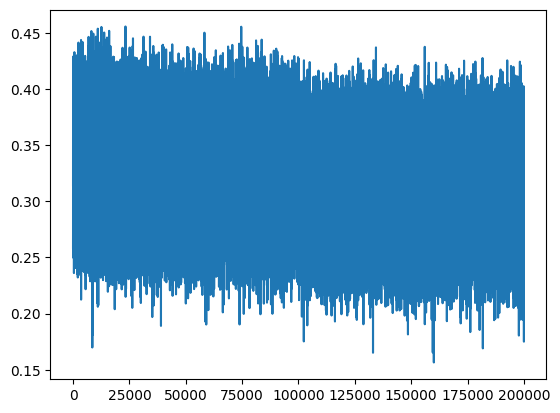

In [329]:
plt.plot(stepi, lossi)

In [279]:
# training split 80% -> optimize params with gradient descent
# dev/validation split 10% -> optimizing hyperparameters
# test split 10% -> check model performance

In [272]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(2)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182534, 3]) torch.Size([182534])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22849, 3]) torch.Size([22849])


In [330]:
# evaluation
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0639, grad_fn=<NllLossBackward0>)

In [331]:
# evaluation
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1435, grad_fn=<NllLossBackward0>)

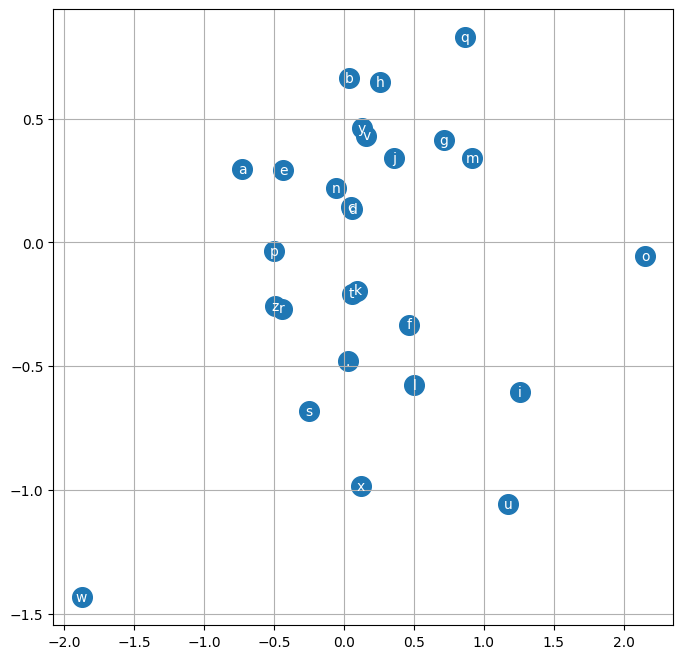

In [332]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [333]:
# iteratively change size of hidden layer(and bias, and first dimension of next layer),
# or change the embedding dimensions (and the first dimension of the hidden layer),
# or change context size,
# or change learning rate, its evolution
# or change minibatch size

In [349]:
g = torch.Generator().manual_seed(214783647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # ...
    while True:
        emb = C[torch.tensor([context])] # [1, block_size, emb_dim]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        # word finalized
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

ryelle.
zollemy.
aj.
elissleya.
ohani.
amaishoni.
linwgye.
paithaire.
den.
kel.
hazpensley.
armiah.
evyn.
ladarsha.
oxi.
cramora.
loyani.
eighailey.
nyi.
oma.
